## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

## Defining The Dataframe

In [2]:
#Managing the data path
train_path='../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

data = {'label':[],'file':[]}
for folder in os.listdir(train_path):
    label_folder = os.path.join(train_path, folder)
    for file in os.listdir(label_folder):
        data['label'].append(folder)
        data['file'].append(os.path.join(train_path,folder,file))

dftrain=pd.DataFrame(data)
dftrain.head()

,label,file
0,N,../input/asl-alphabet/asl_alphabet_train/asl_a...
1,N,../input/asl-alphabet/asl_alphabet_train/asl_a...
2,N,../input/asl-alphabet/asl_alphabet_train/asl_a...
3,N,../input/asl-alphabet/asl_alphabet_train/asl_a...
4,N,../input/asl-alphabet/asl_alphabet_train/asl_a...


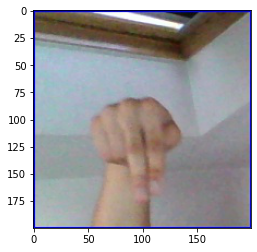

In [3]:
plt.imshow(mpimg.imread(dftrain.iloc[0,1]))

## Preprocessing

In [4]:
dtrain, dtest = train_test_split(dftrain, test_size=0.2, random_state=5)

In [5]:
img_width, img_height=64,64

traindatagen = ImageDataGenerator(rescale=1./255)
testdatagen = ImageDataGenerator(rescale=1./255)

traingen = traindatagen.flow_from_dataframe(
                            dataframe=dtrain,
                            x_col='file',
                            y_col='label',
                            target_size=(img_width,img_height),
                            class_mode='categorical'
                            )

testgen = testdatagen.flow_from_dataframe(
                            dataframe=dtest,
                            x_col='file',
                            y_col='label',
                            target_size=(img_width,img_height),
                            class_mode='categorical'
                            )



Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


## Defining The Model

In [6]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=[5,5], activation='relu',input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(filters=64,kernel_size=[3,3], activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64,kernel_size=[3,3], activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation = "softmax"))

2022-04-10 12:38:37.081394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:38:37.174083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:38:37.175102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:38:37.177462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
#Early Stop Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback = EarlyStopping(monitor='val_loss', patience=2)

In [9]:
history = model.fit(traingen,
                   epochs=50,
                   validation_data=testgen,
                   callbacks=[callback])

2022-04-10 12:38:39.964852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-10 12:38:41.636265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2175/2175 [==============================] - 652s 297ms/step - loss: 0.9365 - accuracy: 0.7031 - val_loss: 0.1938 - val_accuracy: 0.9372
Epoch 2/50
2175/2175 [==============================] - 145s 67ms/step - loss: 0.1818 - accuracy: 0.9379 - val_loss: 0.0499 - val_accuracy: 0.9842
Epoch 3/50
2175/2175 [==============================] - 137s 63ms/step - loss: 0.1127 - accuracy: 0.9621 - val_loss: 0.0202 - val_accuracy: 0.9931
Epoch 4/50
2175/2175 [==============================] - 137s 63ms/step - loss: 0.0842 - accuracy: 0.9727 - val_loss: 0.0214 - val_accuracy: 0.9934
Epoch 5/50
2175/2175 [==============================] - 138s 63ms/step - loss: 0.0739 - accuracy: 0.9768 - val_loss: 0.0516 - val_accuracy: 0.9819


In [10]:
#model.save('asl_model.h5')

##Evaluating The Model

In [11]:
score=pd.DataFrame(history.history)
score.head()

,loss,accuracy,val_loss,val_accuracy
0,0.936524,0.703103,0.193848,0.937184
1,0.181843,0.937902,0.049872,0.984195
2,0.112735,0.962069,0.020187,0.993103
3,0.084152,0.972730,0.021396,0.993391
4,0.073864,0.976810,0.051622,0.981897


In [12]:
sns.lineplot(data=score[['acc','val_acc']])

KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"